# Context

## Installing requirements

In [ ]:
#!pip install -r requirements.txt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing required libraries

In [ ]:
import nltk
nltk.download("all")

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
import os
#some other libraries may be imported later in the notebook

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

# Data

## Loading data

The various columns present in the dataset are:
- `target`: the polarity of the tweet (positive or negative)
- `ids`: Unique id of the tweet
- `date`: the date of the tweet
- `flag`: It refers to the query. If no such query exists then it is NO QUERY.
- `user`: It refers to the name of the user that tweeted
- `text`: It refers to the text of the tweet

In [5]:
# load the data
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS=['target','ids','date','flag','user','text']
df = pd.read_csv('/content/drive/MyDrive/DL data/emotions.csv', encoding =DATASET_ENCODING,names=DATASET_COLUMNS)

## Exploring data

### Global data

In [6]:
print("Dataset size:", len(df))   

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
# global names
TARGET = 'target'

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
#checking if there are empty columns
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

***There aren't any empty columns, this is helpful for prerocessing***

### Tweets analysis

In [12]:
texts = df['text']   #we aisolate the text column to analyze it

In [13]:
text_lens = [len(t.split()) for t in texts.values]  #we make a wordcount of every text and we get the mean.
len_mean = np.mean(text_lens)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


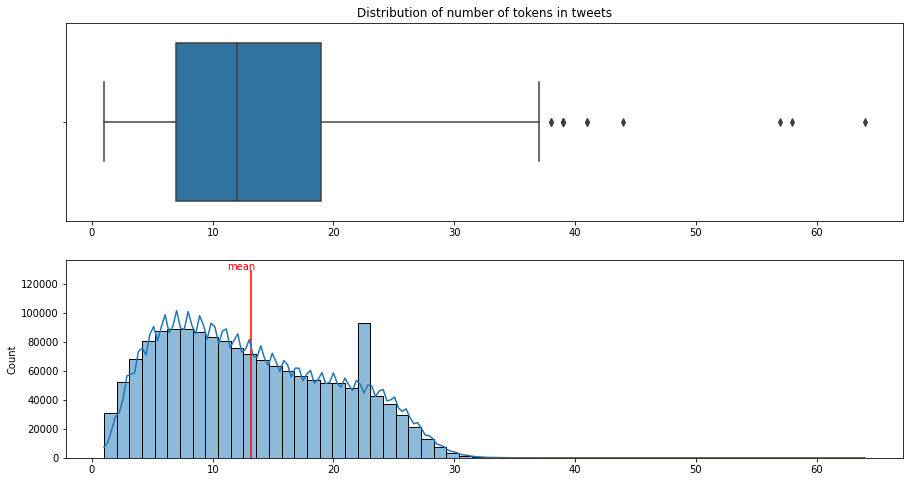

In [14]:
#we plot the wordcount and its mean

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of number of tokens in tweets')
sns.boxplot(text_lens, ax=axes[0])
sns.histplot(text_lens, bins=60, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 130000, color = 'r')
plt.annotate("mean", xy=(len_mean, 130000), xytext=(len_mean-2, 130000),
            color='r')
plt.show()

###Target Analysis

In [18]:
#we change the names
sentiment_dict = {0:"negative", 4:"positive"}


target_balance = df[TARGET].value_counts().rename(index=sentiment_dict)




print(target_balance)

negative    800000
positive    800000
Name: target, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


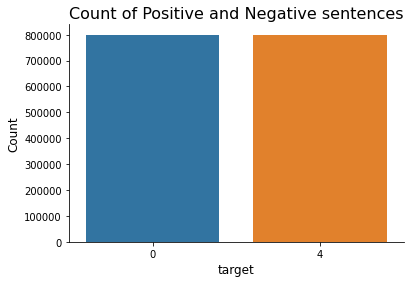

In [83]:
plt.title('Count of Positive and Negative sentences', size=16)
sns.countplot(df.target)
plt.ylabel('Count', size=12)
plt.xlabel('target', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

***Target categories are equal size, so resampling is not required***

In [20]:
# top words
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
#let's extend the list to add "im" as we found it was not originally in the stopword list
stopwords_list.append("im")

word_counts = { 4: [],  #positive
                0: []}  #negative

pattern = re.compile('[^\w ]')
for text, target in zip(df['text'], df[TARGET]):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[target].extend(text)

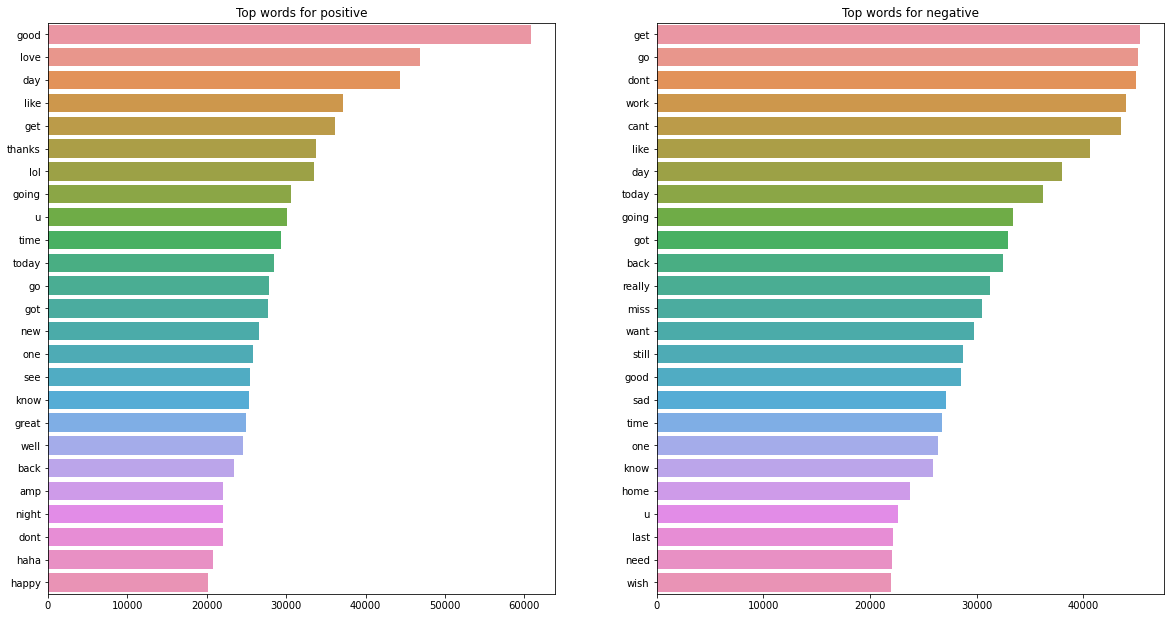

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20,10.5))
def changename(target):
    if target == 4:
        return ("positive")
    else:
        return ("negative")
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {changename(target)}')
plt.show()

In [22]:
# we can see some similar words but also we can see a clear difference given that the top positive words are words like "good, love, happy"

We can see some similar words but also we can see a clear difference given that the top positive words are words like "good, love, happy".
We can also plot some word cloud for each categories of words

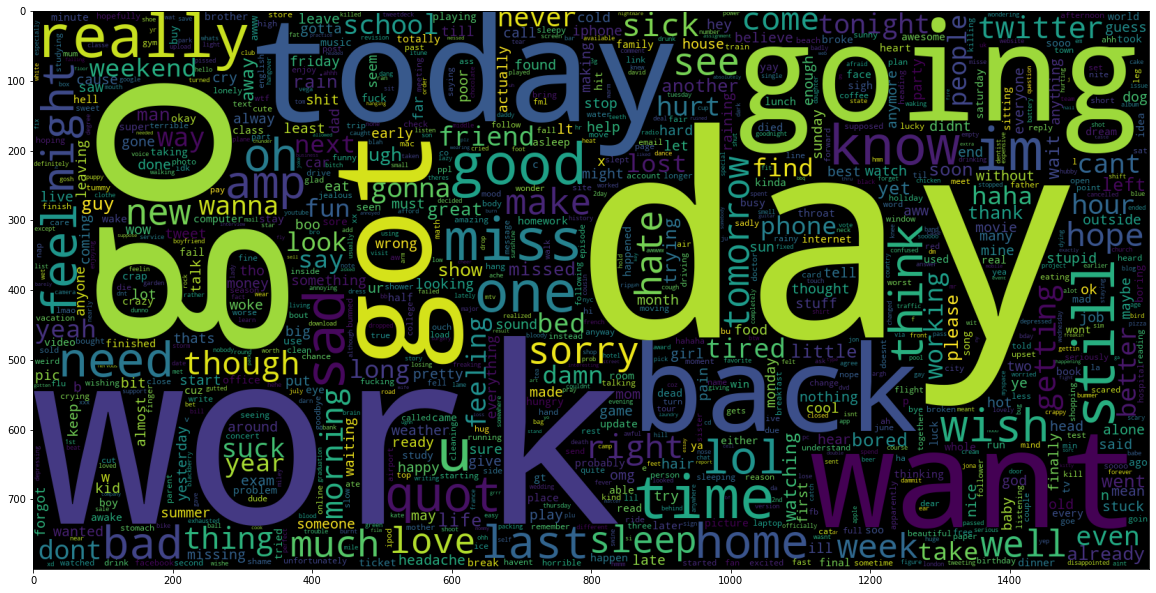

In [84]:
from wordcloud import WordCloud
# Plot a cloud of words for negative tweets :
data_neg = df['text'][:800000] # selecting the negative tweets.
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

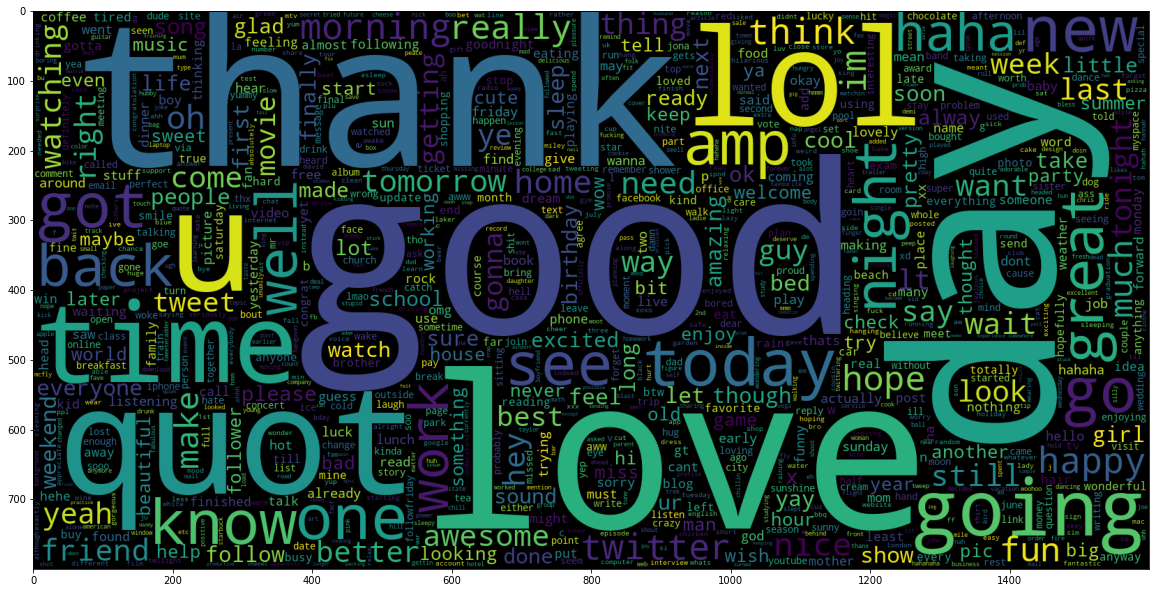

In [86]:
# Plot a cloud of words for positive tweets :
data_pos = df['text'][800000:]  # selecting the positive tweets.
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join(data_pos))
plt.figure(figsize=(20, 20))
plt.imshow(wc)

## Preprocessing data


> Before training the model, we will perform various pre-processing steps on the dataset such as: 
>- Removing outliers.
>- Removing stop words.
>- Converting the text document to lowercase for better generalization.
>- Cleaning the ponctuation (to reduce unnecessary noise from the dataset).
>- Removing the repeating characters from the words along with removing the URLs as they do not have any significant importance. <br>                          

> We will then performe 
>- **`Stemming`** : reducing the words to their derived stems.
>- **`Lemmatization`** : reducing the derived words to their root form known as lemma for better results.

### Removing outliers

In [16]:
outliers = df['text'][np.array(text_lens) > 35] # now we try to identify and exclude the outliers
print(len(outliers))

23


In [17]:
for idx in outliers.index:
    print(idx, 'Target', df[TARGET][idx])
    print(outliers[idx])
    print('///////////////////////////////'*4, '\n')

109664 Target 0
Who Am I Lying ! ? ! I Know , You Know , We All Know , My Ass Is Still Gonna Be Up . Hehe . My Ass Can't Sleep . I Need Help . For Real ! 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

336344 Target 0
I never get 2 c u as often as I like,I never get 2 hug in my every nite  but in my heart i know u r the one i luv n can't never let u go
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

374042 Target 0
I hate this , why does he have to be my step cousin  oh well , he keeps comin on to me ;) ha ha im in such a good mood , jesus , im tw ...
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

461028 Target 0
Is the saddest zornes ever thanks to the magic ( :  ( :  ( :  ( :  ( :  (  :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :   ...
//

*As we can see these outliers seem to be fairly legitimate examples, the ones who don't are mainly because of punctuation exceses and that we can get rid of in the preprocessing step*

### Removing stopwords, stemming and removing special characters and tags/ links

In [23]:
import nltk
from  nltk.stem import SnowballStemmer


stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TO_CLEAN = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [24]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TO_CLEAN, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min, sys: 427 ms, total: 1min
Wall time: 1min 3s


###Splitting

In [26]:
TRAIN_SIZE = 0.8
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


###Vectorizing data

In [27]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 7.32 s, sys: 1.34 s, total: 8.65 s
Wall time: 8.65 s


In [28]:
print(documents[0])

['ya', 'quot', 'like', 'palm', 'pre', 'touchstone', 'charger', 'readynow', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch']


In [30]:
# we use this algorithm to learn word associations from a large corpus of text.
import gensim

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10



w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [31]:
w2v_model.build_vocab(documents)

In [36]:
words = list(w2v_model.wv.index2word)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [37]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 22min 42s, sys: 6.3 s, total: 22min 48s
Wall time: 11min 55s


(263124473, 295270528)

In [38]:
w2v_model.wv.most_similar("love")

[('luv', 0.5756838321685791),
 ('loves', 0.5534821152687073),
 ('loved', 0.5444053411483765),
 ('adore', 0.5093357563018799),
 ('looove', 0.4987291693687439),
 ('amazing', 0.49790850281715393),
 ('awesome', 0.4645862579345703),
 ('loooove', 0.46332624554634094),
 ('loveee', 0.4555068910121918),
 ('lovee', 0.4412972331047058)]

###Tokenizing text data

In [39]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text) 
# Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 20.5 s, sys: 274 ms, total: 20.8 s
Wall time: 20.9 s


### Uniforming texts' length

In [49]:
%%time
from keras_preprocessing.sequence import pad_sequences

# text_to_sequences transforms each text in texts to a sequence of integers. 
#So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary

SEQUENCE_LENGTH = 300

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)  
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

#pad_sequences is used to ensure that all sequences in a list have the same length

CPU times: user 30.6 s, sys: 2.15 s, total: 32.8 s
Wall time: 32.8 s


### Label Encoder

In [41]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [42]:
%%time
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
#we change the numerical values for the target sentiment

CPU times: user 435 ms, sys: 14 ms, total: 449 ms
Wall time: 453 ms


In [43]:

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

labels = df_train.target.unique().tolist()
labels2 = df_test.target.unique().tolist()
labels.append(NEUTRAL)
labels2.append(NEUTRAL)
labels2

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [44]:
print(labels)
print(labels2)

['POSITIVE', 'NEGATIVE', 'NEUTRAL']
['NEGATIVE', 'POSITIVE', 'NEUTRAL']


In [45]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [50]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [51]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [52]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [53]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
#we build the embedding layer to map from words to vectors which you can do better analysis

# Model: building & training

## Building

In [54]:
from keras.models import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [89]:

from keras.utils import plot_model 

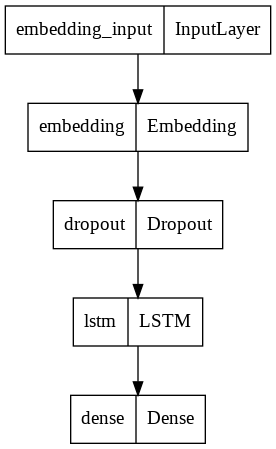

In [90]:
keras.utils.plot_model(model,to_file='LSTM.png')

## Compiling

In [55]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Callbacks

In [56]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),   #Reduce learning rate when a metric has stopped improving. 
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]    #Stop training when a monitored metric has stopped improving.

## Training

In [57]:
%%time

BATCH_SIZE = 1024
EPOCHS = 1             #there should be more but for the sake of time let's just do 1 epoch

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

1125/1125 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.7511 

1125/1125 [==============================] - 14373s 13s/step - loss: 0.5025 - accuracy: 0.7511 - val_loss: 0.4644 - val_accuracy: 0.7788 - lr: 0.0010
CPU times: user 6h 53min 58s, sys: 36min 6s, total: 7h 30min 4s
Wall time: 3h 59min 33s


# Evaluation & Prediction

## Evaluation

In [58]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 786s 3s/step - loss: 0.4630 - accuracy: 0.7798

ACCURACY: 0.7798156142234802
LOSS: 0.4629892110824585
CPU times: user 23min 18s, sys: 1min 29s, total: 24min 47s
Wall time: 13min 5s


## Prediction

In [59]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [60]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [61]:
predict("I'm having a bad day")

1/1 [==============================] - 0s 373ms/step


{'label': 'NEGATIVE',
 'score': 0.047278452664613724,
 'elapsed_time': 0.4264254570007324}

In [62]:
predict("I hate the way he looks at me")

1/1 [==============================] - 0s 64ms/step


{'label': 'NEGATIVE',
 'score': 0.04718393087387085,
 'elapsed_time': 0.11003875732421875}

In [63]:
predict("Today I will finally make it")

1/1 [==============================] - 0s 62ms/step


{'label': 'POSITIVE',
 'score': 0.9293755292892456,
 'elapsed_time': 0.11572718620300293}

In [64]:
predict("Sometimes I don't know what I'm thinking")

1/1 [==============================] - 0s 64ms/step


{'label': 'NEUTRAL',
 'score': 0.5455045700073242,
 'elapsed_time': 0.10788130760192871}

## Classification Report


In [65]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

scores = model.predict(x_test, verbose=1, batch_size=8000)
y_test_1d = list(df_test.target)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

print(classification_report(y_test_1d, y_pred_1d))

40/40 [==============================] - 897s 22s/step
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.76      0.77    159494
    POSITIVE       0.77      0.80      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



## Confusion matrix

In [69]:
confusion_matrix = confusion_matrix(y_test_1d, y_pred_1d)

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

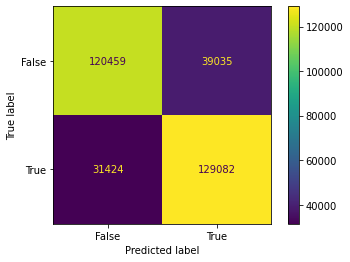

In [73]:
cm_display.plot()
plt.show()

## Accuracy Score

In [66]:
accuracy_score(y_test_1d, y_pred_1d)

0.779815625

# Pretrained model

In [ ]:
#install vaderSentimentlibrary
!pip install vaderSentiment

In [76]:
#import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return negative, neutral, positive, compound, overall_sentiment

In [79]:
sentiment_vader("Sometimes I don't know what I'm thinking")

(0.0, 1.0, 0.0, 0.0, 'Neutral')